In [1]:
%matplotlib inline
import sklearn
import pandas
import numpy
import matplotlib.pyplot as plt

import trackml.dataset
import trackml.score

import os.path
import sys

In [2]:
path_to_train = 'train_100_events.zip'
event_prefix = "event000001001"
#path = os.path.join(path_to_train, event_prefix)
path = 'train_sample.zip'

events = pandas.DataFrame()
datas = []
for e in trackml.dataset.load_dataset(path, nevents=3):
    event_id, hits, cells, particles, truth = e
    data = hits.merge(truth)
    data['event_id'] = event_id
    events = data
    datas.append(data)
events = pandas.concat(datas)

events.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,event_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000,1000
1,2,-55.336102,0.635342,-1502.5,7,2,1,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010,1000
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000,1000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008,1000
4,5,-62.673599,-9.371200,-1502.5,7,2,1,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009,1000


In [3]:
events['event_id'].unique(), len(events)

(array([1000, 1001, 1002]), 340123)

In [7]:
from sklearn.preprocessing import StandardScaler

def single_features(hits, target=True):
    
    # From DBSCAN benchmark
    # https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
    x = hits.x.values
    y = hits.y.values
    z = hits.z.values
    xy_scale = numpy.sqrt(x**2 + y**2 + z**2)
    xnorm = x/xy_scale
    ynorm = y/xy_scale
    z_scale = numpy.sqrt(x**2 + y**2)
    znorm = z/z_scale
    
    nn = StandardScaler().fit_transform([xnorm, ynorm, znorm])
    features = pandas.DataFrame({
        'xnorm': nn[0],
        'ynorm': nn[1],
        'znorm': nn[2],
    })

    return features

hits = single_features(events)
#hits.index
hits['particle_id'] = events['particle_id'].values

In [8]:
# Sample hits for training, a mix of hits from same track and from different
def make_pairs(df, idcol='particle_id'):
    q = '{}_b != {}_a'.format(idcol, idcol)
    p = df.merge(df, on=df.assign(key_col=1)['key_col'], suffixes=('_a', '_b'))
    #p = p.query(q) # filter out joins on the same row
    p = p.reset_index(drop=True)
    
    #f = p[p['particle_id_a'] != p['particle_id_b']]
    #print(f)
    
    return p

def sample_pairs(n_particles, n_hits=10, random_state=None):
    
    particles = hits['particle_id'].sample(n=n_particles, random_state=random_state)
    samples = []
    for particle in particles:
        matches = hits[hits['particle_id'] == particle].sample(n=n_hits, replace=True, random_state=random_state)
        nonmatches = hits[hits['particle_id'] != particle].sample(n=n_hits//2, replace=True, random_state=random_state)

        d = pandas.concat([matches, nonmatches])
        pairs = make_pairs(d)
        pairs['matches'] = pairs['particle_id_a'] == pairs['particle_id_b']        
        samples.append(pairs)

    samples = pandas.concat(samples)
    return samples


In [224]:
def pair_features(pairs, target=True): 
    features = pandas.DataFrame()

    # Distance
    features['xd'] = numpy.abs(pairs['xnorm_a'] - pairs['xnorm_b'])
    features['yd'] = numpy.abs(pairs['ynorm_a'] - pairs['ynorm_b'])
    features['zd'] = numpy.abs(pairs['znorm_a'] - pairs['znorm_b'])
    
    # Position
    #features['xa'] = pairs['xnorm_a']
    #features['ya'] = pairs['ynorm_a']
    #features['za'] = pairs['znorm_a']
    
    # Target
    if target:
        features['matches'] = pairs['matches']
    
    return features

pairs = sample_pairs(400, random_state=2)
data = pair_features(pairs)
data.shape, data.matches.mean(), len(pairs['particle_id_a'].unique())


#data[data.matches==False].head(n=2)
#data[data.matches==True].head(n=2)

((90000, 4), 0.48477777777777775, 403)

In [10]:
#data[['xd', 'yd', 'zd']].groupby(data['matches']).hist(figsize=(16,8), bins=40, alpha=0.8)

In [225]:
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5), metric=None):
    np = numpy
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    s = model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=metric)
    train_sizes, train_scores, test_scores = s
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [226]:
def plot_forest_importance(forest, X):
    importances = forest.feature_importances_
    std = numpy.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = numpy.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %d : %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]), )

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Feature importances")
    ax.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #ax.set_xticks(range(X.shape[1]), indices)
    #ax.set_xlim([-1, X.shape[1]])
    return fig

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] min_samples_split=0.05, n_estimators=20 .........................
[CV] .......... min_samples_split=0.05, n_estimators=20, total=   1.7s
[CV] min_samples_split=0.05, n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .......... min_samples_split=0.05, n_estimators=20, total=   1.6s
[CV] min_samples_split=0.05, n_estimators=20 .........................
[CV] .......... min_samples_split=0.05, n_estimators=20, total=   1.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.6s finished


Using parameters {'min_samples_split': 0.05, 'n_estimators': 20}
Test set score: 0.93


<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

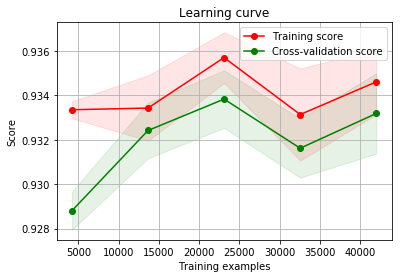

In [333]:
from sklearn import model_selection, metrics

test_size = 0.3
seed = 1

target_columns = ['matches']
data_columns = list(set(data.columns) - set(target_columns))

s = model_selection.train_test_split(data[data_columns], data[target_columns], test_size=test_size, random_state=seed)
X_train, X_test, Y_train, Y_test = s
Y_train = Y_train['matches']
Y_test = Y_test['matches']

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

metric = 'average_precision'

estimator = RandomForestClassifier()
parameters = {
    'n_estimators': [ 20 ],
    'min_samples_split': [ 0.05 ],
}
search = model_selection.GridSearchCV(estimator, parameters, cv=3, verbose=2, scoring=metric)
search.fit(X_train, Y_train)

# Evaluation
print('Using parameters', search.best_params_)
score = metrics.get_scorer(metric)(search.best_estimator_, X_test, Y_test)
print('Test set score: %.2f' % (score,))

plot_learning_curve(search.best_estimator_, 'Learning curve', X_train, Y_train, metric=metric)

In [334]:
cm = metrics.confusion_matrix(search.best_estimator_.predict(X_test), Y_test)
cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

array([[0.79336341, 0.20663659],
       [0.10150689, 0.89849311]])

In [335]:
# Validation set
a = pair_features(sample_pairs(20, random_state=11))
b = pair_features(sample_pairs(20, random_state=12))
c = pair_features(sample_pairs(20, random_state=13))
validate = pandas.concat([a, b, c])
X_valid = validate[data_columns]
Y_valid = validate[target_columns]

cm = metrics.confusion_matrix(search.best_estimator_.predict(X_valid), Y_valid)
cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

array([[0.82778489, 0.17221511],
       [0.27716492, 0.72283508]])

Feature ranking:
1. 2 : xd (0.340677)
2. 0 : yd (0.331301)
3. 1 : zd (0.328022)


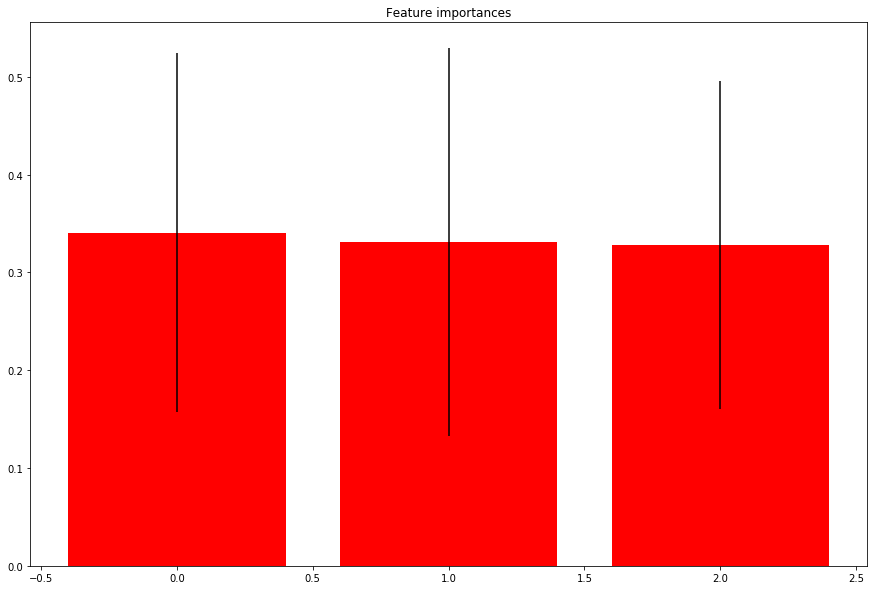

In [16]:
plot_forest_importance(search.best_estimator_, X_train);

In [337]:
# The default pairwise_distance calculation in sklearn some limitations on large datasets with custom metric
# 1. it does not support sparse outputs, causing high memory usage
# 2. the metric function , causing slowdown due to Python call overhead
# 
# An alternative would be NearestNeighbors.radius_neighbors_graph() though it still has 2.
#
# Here we calculate the distances in chuncks, and then cull values above @max_distance to build a sparse matrix
def pairwise_distance_sparse_fast(X, func, max_distance, chunksize=100, B=None):
    A = X
    if B is None:
        B = X
        
    sparse = None
    for a_row in range(A.shape[0]):
        a = A[a_row, :]
        aa = numpy.repeat([a], B.shape[0], axis=0)

        # Calculate distances between A row and all B values
        dist = func(aa, B)
        #print('func', aa, B, dist)
        
        # Check sparsity
        dist[dist > max_distance] = 0.0 #None#numpy.nan
        s = scipy.sparse.csr_matrix(dist)
        
        # Combine results
        if sparse is None:
            sparse = s
        else:
            sparse = scipy.sparse.vstack([sparse, s], format='csr')
        
    assert sparse.shape == (A.shape[0], B.shape[0]), 'wrong output shape: {}'.format(sparse.shape)
    return sparse

def pairwise_distance_sparse_ref(X, func, max_distance):
    # Compat wrapper for single pair of values to array-of-pairs
    def metric(a, b):
        A = numpy.array([a])
        B = numpy.array([b])
        D = func(A, B)
        #print(A, B, D)
        return D[0]
    dist = sklearn.metrics.pairwise.pairwise_distances(X,metric=metric)
    dist[dist > max_distance] = 0
    sparse = scipy.sparse.csr_matrix(dist)
    return sparse

import scipy


def euclidian_dist(A, B):
    return numpy.sum(numpy.sqrt((A - B)**2), axis=1)

def learned_dist(a, b):
    #print(a.shape, b.shape)
    xd = numpy.abs(a[:,0] - b[:,0]).reshape(-1, 1)
    yd = numpy.abs(a[:,1] - b[:,1]).reshape(-1, 1)
    zd = numpy.abs(a[:,2] - b[:,2]).reshape(-1, 1)
    pairs = numpy.hstack([xd, yd, zd])
    #print('x', zd.shape, pairs.shape)
    estimator = search.best_estimator_
    # Distance is probability of not being a match
    dist = estimator.predict_proba(pairs)[:,0]
    return dist

maxd=0.4
distance = learned_dist

A = numpy.random.random((20, 3))
s = time.time()
R = pairwise_distance_sparse_ref(A, distance, max_distance=maxd)
s1 = time.time()
F = pairwise_distance_sparse_fast(A, distance, max_distance=maxd)
s2 = time.time()
print('time', s1-s, s2-s1, '\n')
def sparcity(S):
    return S.getnnz() / numpy.product(S.shape) 
print('fill grade', sparcity(R))
sdiff = abs(sparcity(R) - sparcity(F))
assert sdiff < 0.001
diff = (R - F).toarray()
#print(diff, '\n')
assert numpy.nansum(diff) < 0.001, numpy.nansum(diff)
#print(R.toarray(), '\n')
#print(F.toarray(), '\n')


time 1.2477777004241943 0.1625652313232422 

fill grade 0.465


In [276]:
%load_ext line_profiler

In [338]:
%lprun -f learned_dist pairwise_distance_sparse_fast(A, distance, max_distance=maxd)

In [340]:
import time

from sklearn import cluster

# Ridicouslou slow when used as metric=func
def distance(a, b):
    A = pandas.DataFrame(data={'xnorm': a[0], 'ynorm': a[1], 'znorm': a[2]}, index=[0]).add_suffix('_a')
    B = pandas.DataFrame(data={'xnorm': b[0], 'ynorm': b[1], 'znorm': b[2]}, index=[0]).add_suffix('_b')
    #pairs = pair_features(numpy.hstack([a, b]))
    pairs = A.join(B)
    pairs = pair_features(pairs, False)
    estimator = search.best_estimator_
    # Distance is probability of not being a match
    dist = estimator.predict_proba(pairs)[0][0]
    #print(dist)
    return dist


def predict(hits, distance=None, max_distance=0.03):
    if distance is None:
        distance = learned_dist
    
    dbscan = cluster.DBSCAN(eps=0.00715, min_samples=1, algorithm='ball_tree', n_jobs=-1, metric='precomputed')

    hits = single_features(hits, target=False)
    X = pairwise_distance_sparse_fast(hits.values, distance, max_distance=max_distance)
    print('pairs', X.shape, sparcity(X))
    return dbscan.fit_predict(X)

def run_make_submission():
    np = numpy
    pd = pandas
    
    data_dir = 'test.zip'
    submissions = []

    events = 1
    start_time = time.time()
    for event_id, hits in trackml.dataset.load_dataset(data_dir, parts=['hits'], nevents=events):
        print('event_id : ', event_id, hits.shape[0], time.time()-start_time)

        hits = hits[:10000] #FIXME: temp
        track_id = predict(hits)
        print('tracks : ', len(hits), numpy.unique(track_id).shape, time.time()-start_time)
        
        # Prepare submission for an event
        predictions = np.column_stack(([event_id,]*len(hits), hits.hit_id.values, track_id))
        submission = pd.DataFrame(columns=['event_id', 'hit_id', 'track_id'], data=predictions).astype(int)
        submissions.append(submission)

    # Create submission file
    submission = pd.concat(submissions, axis=0)
    submission.to_csv('submission.csv.gz', index=False, compression='gzip')
    
run_make_submission()

event_id :  0 119016 0.42577123641967773
(10000, 3)
(10000, 10000) 0.0042732
tracks :  10000 (804,) 481.9008560180664
